# Merge Garmin .FIT and Lyfta CSV

This notebook extracts heart-rate time-series from a Garmin `.fit` file and merges it set-by-set with a Lyfta CSV export (the CSV format you provided). It includes parsing, visualization, HR peak-based set detection, and produces a merged CSV with per-set HR metrics.

**How to use**:
1. Upload your `Lyfta` CSV and the Garmin `.fit` file into the environment or set their paths in the **Run the merge** cell.
2. Run the cells sequentially. Tune peak-detection parameters interactively if results need adjustments.

**Notes**:
- This notebook expects Python packages `fitparse`, `pandas`, `numpy`, `scipy`, and `matplotlib`. If they're missing, run the install cell below.
- The FIT parsing uses `fitparse`; if you prefer `fitdecode` you can adapt the code.


In [2]:
%%bash
python3 -V
# Install required packages (uncomment to run in your environment)
# pip install fitparse pandas numpy scipy matplotlib

# If running on a managed environment where pip is restricted, install in a venv or run locally.

Python 3.8.10


In [9]:
python3 -m pip install --upgrade pip

SyntaxError: invalid syntax (3917727154.py, line 1)

In [6]:
import os
from datetime import datetime, timedelta
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install fitparse --user

python3 -m pip install --upgrade pip

# FIT parsing
from fitparse import FitFile
from scipy.signal import find_peaks

print('imports ok')


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
imports ok


In [24]:
def is_activity_match(lyfta_start, fit_start, tolerance_minutes=180):
    """
    Return True if lyfta_start and fit_start are within tolerance_minutes.
    Default tolerance 180 minutes (3 hours). Adjust to 60-720 as needed.
    """
    if lyfta_start is None or fit_start is None:
        return False
    # ensure both are datetime
    try:
        ls = pd.to_datetime(lyfta_start)
        fs = pd.to_datetime(fit_start)
    except Exception:
        return False
    diff = abs((ls - fs).total_seconds()) / 60.0
    return diff <= tolerance_minutes


def parse_lyfta_csv(path):
    import pandas as pd
    df = pd.read_csv(path, dtype=str)
    # normalize column names
    df.columns = [c.strip() for c in df.columns]
    # helpful debug
    print("Detected columns:", df.columns.tolist())

    # find columns
    title_col = next((c for c in df.columns if c.lower().strip() == 'title'), None)
    date_col  = next((c for c in df.columns if c.lower().strip() == 'date' or 'time' in c.lower()), None)
    exercise_col = next((c for c in df.columns if c.lower().strip() == 'exercise' or 'exercise' in c.lower()), None)
    weight_col = next((c for c in df.columns if c.lower().strip() == 'weight'), None)
    reps_col = next((c for c in df.columns if c.lower().strip() in ('reps','rep')), None)
    duration_col = next((c for c in df.columns if c.lower().strip() == 'duration'), None)
    set_type_col = next((c for c in df.columns if c.lower().strip() == 'set type'), None)

    if date_col is None or exercise_col is None:
        raise ValueError(f"Missing required columns. Found: {list(df.columns)}")

    try:
        workout_start = pd.to_datetime(df.iloc[0][date_col])
    except Exception:
        workout_start = pd.to_datetime(df.iloc[0][date_col], infer_datetime_format=True)

    workout_info = {
        'title': df.iloc[0][title_col] if title_col else 'Workout',
        'start_time': workout_start.to_pydatetime(),
        'duration_text': df.iloc[0][duration_col] if duration_col else None,
        'n_sets': len(df)
    }

    sets = []
    for i, row in df.iterrows():
        sets.append({
            'set_index': int(i),
            'exercise': row.get(exercise_col),
            'weight': float(row.get(weight_col)) if weight_col and pd.notna(row.get(weight_col)) else None,
            'reps': int(row.get(reps_col)) if reps_col and pd.notna(row.get(reps_col)) else None,
            'set_type': row.get(set_type_col) if set_type_col else None
        })

    return workout_info, sets



def parse_fit_file(fit_path):
    fitfile = FitFile(fit_path)
    records = []
    activity_start = None
    total_elapsed = None
    garmin_sets = []
    for msg in fitfile.get_messages():
        name = msg.name
        if name == 'file_id':
            for d in msg:
                if d.name == 'time_created' and d.value:
                    activity_start = d.value if activity_start is None else activity_start
        elif name == 'session':
            for d in msg:
                if d.name == 'start_time' and d.value:
                    activity_start = d.value
                if d.name in ('total_elapsed_time','total_timer_time') and d.value:
                    total_elapsed = float(d.value)
        elif name == 'lap':
            lap_start = None
            lap_end = None
            for d in msg:
                if d.name == 'start_time':
                    lap_start = d.value
                if d.name == 'timestamp':
                    lap_end = d.value
            if lap_start and lap_end:
                garmin_sets.append({'start': lap_start, 'end': lap_end})

    # collect records
    fitfile = FitFile(fit_path)
    for record in fitfile.get_messages('record'):
        rec = {}
        for d in record:
            rec[d.name] = d.value
        if 'timestamp' in rec:
            hr = rec.get('heart_rate', None)
            records.append({'timestamp': rec['timestamp'], 'heart_rate': hr})

    hr_df = pd.DataFrame(records)
    hr_df = hr_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])
    hr_df['timestamp'] = pd.to_datetime(hr_df['timestamp'])
    hr_df = hr_df.sort_values('timestamp').reset_index(drop=True)
    if hr_df['heart_rate'].isna().all():
        raise ValueError('FIT HR records exist but heart_rate values are all missing.')
    hr_df['heart_rate'] = hr_df['heart_rate'].ffill().bfill().astype(float)
    if activity_start is None:
        activity_start = hr_df['timestamp'].iloc[0]
    if total_elapsed is None:
        total_elapsed = (hr_df['timestamp'].iloc[-1] - hr_df['timestamp'].iloc[0]).total_seconds()
    return {
        'activity_start': activity_start, 
        'total_elapsed': float(total_elapsed), 
        'hr_df': hr_df, 
        'garmin_sets': garmin_sets
    }

def detect_sets_from_hr(hr_df, expected_n_sets, min_peak_distance_seconds=30, min_peak_prominence=6):
    df = hr_df.copy().set_index('timestamp')
    df = df.resample('1S').mean().interpolate()
    hr = df['heart_rate'].values
    times = df.index.to_pydatetime()
    if len(hr) < 5:
        return []
    baseline = np.median(hr[:max(1, min(30, len(hr)))])
    distance = int(min_peak_distance_seconds)
    peaks, props = find_peaks(hr, distance=distance, prominence=min_peak_prominence)
    if len(peaks) == 0:
        return []
    prominences = props.get('prominences', np.ones(len(peaks)))
    peak_info = sorted(zip(peaks, prominences), key=lambda x: -x[1])
    selected_peaks = sorted([p for p, _ in peak_info[:expected_n_sets]])
    windows = []
    for p in selected_peaks:
        peak_time = times[p]
        thr = baseline + 0.33 * prominences[list(peaks).index(p)] if len(prominences)>0 else baseline + 3
        left = p
        while left > 0 and hr[left] > thr:
            left -= 1
        right = p
        while right < len(hr)-1 and hr[right] > thr:
            right += 1
        start = times[left]
        end = times[right]
        windows.append({'start': start, 'end': end, 'peak': peak_time})
    return windows


def equal_split_windows(activity_start, activity_end, n):
    total = (activity_end - activity_start).total_seconds()
    windows = []
    for i in range(n):
        s = activity_start + timedelta(seconds=(i * total / n))
        e = activity_start + timedelta(seconds=((i+1) * total / n))
        windows.append({'start': s, 'end': e, 'peak': s + (e - s)/2})
    return windows


def compute_metrics_for_window(hr_df, window):
    s = pd.to_datetime(window['start'])
    e = pd.to_datetime(window['end'])
    mask = (hr_df['timestamp'] >= s) & (hr_df['timestamp'] <= e)
    slice_df = hr_df.loc[mask]
    if slice_df.empty:
        nearest_idx = (hr_df['timestamp'] - s).abs().idxmin()
        sample = hr_df.loc[nearest_idx]
        avg_hr = float(sample['heart_rate'])
        max_hr = float(sample['heart_rate'])
        duration = (e - s).total_seconds()
        hr_curve = [{'ts': str(sample['timestamp']), 'hr': sample['heart_rate']}]
        return {'avg_hr': avg_hr, 'max_hr': max_hr, 'duration': duration, 'hr_curve': hr_curve}
    avg_hr = float(slice_df['heart_rate'].mean())
    max_hr = float(slice_df['heart_rate'].max())
    duration = (e - s).total_seconds()
    hr_curve = [{'ts': str(r['timestamp']), 'hr': float(r['heart_rate'])} for _, r in slice_df.iterrows()]
    return {'avg_hr': avg_hr, 'max_hr': max_hr, 'duration': duration, 'hr_curve': hr_curve}


In [23]:
# Example: plot HR curve and mark detected peaks/windows
def plot_hr_and_windows(hr_df, windows=None, title='HR'): 
    plt.figure(figsize=(12,4))
    plt.plot(hr_df['timestamp'], hr_df['heart_rate'], label='HR')
    if windows:
        for i,w in enumerate(windows):
            plt.axvspan(pd.to_datetime(w['start']), pd.to_datetime(w['end']), alpha=0.2, label=f'set {i}')
            plt.axvline(pd.to_datetime(w['peak']), linestyle='--', alpha=0.6)
    plt.xlabel('time')
    plt.ylabel('bpm')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

print('plot helper ready')

plot helper ready


In [20]:
p = "data.csv"
df = pd.read_csv(p)
print(df.columns.tolist())
display(df.head(8))

[' Title', 'Date', 'Duration', 'Exercise', 'Superset id', 'Weight', 'Reps', 'Distance', 'Time', 'Set Type']


,Title,Date,Duration,Exercise,Superset id,Weight,Reps,Distance,Time,Set Type
0,Evening session,2025-12-03 13:02:41,01:04:53,Lateral Raise,NaN,10.0,10,NaN,NaN,NORMAL_SET
1,Evening session,2025-12-03 13:02:41,01:04:53,Lateral Raise,NaN,10.0,10,NaN,NaN,NORMAL_SET
2,Evening session,2025-12-03 13:02:41,01:04:53,Lever Leg Extension,NaN,45.0,10,NaN,NaN,NORMAL_SET
3,Evening session,2025-12-03 13:02:41,01:04:53,Lever Leg Extension,NaN,90.0,10,NaN,NaN,NORMAL_SET
4,Evening session,2025-12-03 13:02:41,01:04:53,Lever Leg Extension,NaN,90.0,10,NaN,NaN,NORMAL_SET
5,Evening session,2025-12-03 13:02:41,01:04:53,Lever Seated Reverse Fly,NaN,15.0,10,NaN,NaN,NORMAL_SET
6,Evening session,2025-12-03 13:02:41,01:04:53,Lever Seated Reverse Fly,NaN,15.0,10,NaN,NaN,NORMAL_SET
7,Evening session,2025-12-03 13:02:41,01:04:53,Lever Seated Reverse Fly,NaN,15.0,10,NaN,NaN,NORMAL_SET


Files exist? True True
Detected columns: ['Title', 'Date', 'Duration', 'Exercise', 'Superset id', 'Weight', 'Reps', 'Distance', 'Time', 'Set Type']
Lyfta start: 2025-12-03 13:02:41 Sets: 4769
Garmin start: 2025-12-03 12:03:53 elapsed(s): 3847.293
Detected windows: 66 expected: 4769 -> falling back to equal split
No valid sets with HR found — merged CSV not written.

Summary:
Total lyfta sets: 4769
Merged (with HR): 0


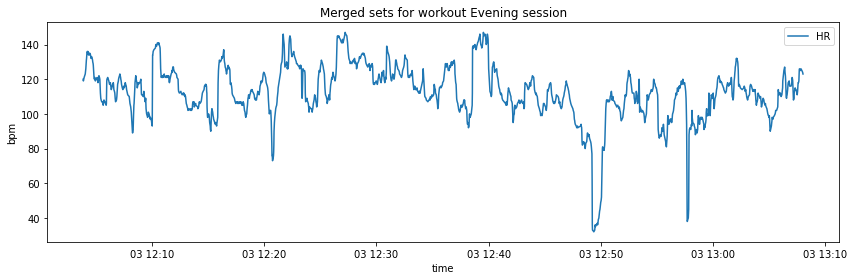

In [26]:
# ----- Configuration -----
LYFTA_CSV = 'data.csv'   # <-- change to your Lyfta CSV path
FIT_PATH   = '21159045593_ACTIVITY.fit'  # <-- change if needed
OUT_CSV    = 'merged_workout.csv'
SKIP_CSV   = 'skipped_sets_no_hr.csv'
TOL_MINUTES = 180   # workout match tolerance in minutes (3 hours). reduce to 60 for stricter matching.
MIN_SAMPLES_PER_SET = 3  # minimum HR samples required in a set window to consider it valid

# ----- Load inputs -----
print('Files exist?', os.path.exists(LYFTA_CSV), os.path.exists(FIT_PATH))
workout_info, lyfta_sets = parse_lyfta_csv(LYFTA_CSV)
fit_parsed = parse_fit_file(FIT_PATH)
print('Lyfta start:', workout_info['start_time'], 'Sets:', workout_info['n_sets'])
print('Garmin start:', fit_parsed['activity_start'], 'elapsed(s):', fit_parsed['total_elapsed'])

# ----- Verify activity-level match before doing any merging -----
matched = is_activity_match(workout_info['start_time'], fit_parsed['activity_start'], tolerance_minutes=TOL_MINUTES)
if not matched:
    print(f"WARNING: Lyfta workout start ({workout_info['start_time']}) and FIT activity start ({fit_parsed['activity_start']}) differ by more than {TOL_MINUTES} minutes.")
    print("Skipping merge. If this is the correct FIT, increase tolerance or check timestamps.")
    # Optionally you could continue with a prompt; for now we abort processing by ending cell execution.
    raise SystemExit("FIT and Lyfta timestamps do not match — aborting merge to avoid false positives.")

# ----- Build windows (try detection, fallback to equal-split) -----
windows = detect_sets_from_hr(fit_parsed['hr_df'], expected_n_sets=workout_info['n_sets'],
                              min_peak_distance_seconds=20, min_peak_prominence=4)
if not windows or len(windows) != workout_info['n_sets']:
    print('Detected windows:', len(windows), 'expected:', workout_info['n_sets'], '-> falling back to equal split')
    activity_end = fit_parsed['activity_start'] + timedelta(seconds=fit_parsed['total_elapsed'])
    windows = equal_split_windows(fit_parsed['activity_start'], activity_end, workout_info['n_sets'])

# ----- Merge but only keep sets that actually have HR samples ----- 
merged_rows = []
skipped_rows = []
hr_df = fit_parsed['hr_df']

for idx, set_rec in enumerate(lyfta_sets):
    w = windows[idx]
    # Ensure windows are within the HR data range — clip
    w_start = max(pd.to_datetime(w['start']), hr_df['timestamp'].iloc[0])
    w_end   = min(pd.to_datetime(w['end']),   hr_df['timestamp'].iloc[-1])
    # If the clipped window is invalid, treat as no-samples
    if w_end <= w_start:
        skipped_rows.append({
            'set_index': idx,
            'exercise': set_rec.get('exercise'),
            'weight': set_rec.get('weight'),
            'reps': set_rec.get('reps'),
            'reason': 'window_outside_hr_range',
            'original_start': w['start'],
            'original_end': w['end']
        })
        continue

    # compute slice
    mask = (hr_df['timestamp'] >= w_start) & (hr_df['timestamp'] <= w_end)
    slice_df = hr_df.loc[mask]
    if slice_df.shape[0] < MIN_SAMPLES_PER_SET:
        # not enough HR samples → skip saving this set
        skipped_rows.append({
            'set_index': idx,
            'exercise': set_rec.get('exercise'),
            'weight': set_rec.get('weight'),
            'reps': set_rec.get('reps'),
            'reason': f'not_enough_hr_samples ({slice_df.shape[0]})',
            'window_start': str(w_start),
            'window_end': str(w_end)
        })
        continue

    # valid set — compute metrics
    avg_hr = float(slice_df['heart_rate'].mean())
    max_hr = float(slice_df['heart_rate'].max())
    duration = (w_end - w_start).total_seconds()
    hr_curve = [{'ts': str(r['timestamp']), 'hr': float(r['heart_rate'])} for _, r in slice_df.iterrows()]

    merged_rows.append({
        'set_index': idx,
        'exercise': set_rec.get('exercise'),
        'weight': set_rec.get('weight'),
        'reps': set_rec.get('reps'),
        'set_start': str(w_start),
        'set_end': str(w_end),
        'set_duration_s': duration,
        'avg_hr': avg_hr,
        'max_hr': max_hr,
        'n_hr_samples': slice_df.shape[0],
        'hr_curve_json': json.dumps(hr_curve)
    })

# ----- Save outputs ----- 
if merged_rows:
    out_df = pd.DataFrame(merged_rows)
    out_df.to_csv(OUT_CSV, index=False)
    print('Saved merged sets to', OUT_CSV)
else:
    print('No valid sets with HR found — merged CSV not written.')

# if skipped_rows:
#     skip_df = pd.DataFrame(skipped_rows)
#     skip_df.to_csv(SKIP_CSV, index=False)
#     print('Saved skipped sets info to', SKIP_CSV)

# ----- Quick summary printout -----
print('\nSummary:')
print('Total lyfta sets:', len(lyfta_sets))
print('Merged (with HR):', len(merged_rows))
# print('Skipped (no HR):', len(skipped_rows))
if merged_rows:
    print('Avg HR across merged sets:', out_df['avg_hr'].mean())
    print('Max HR across merged sets:', out_df['max_hr'].max())

# Visual check: plot only the HR and the windows for merged sets
merged_windows = []
for r in merged_rows:
    merged_windows.append({'start': pd.to_datetime(r['set_start']), 'end': pd.to_datetime(r['set_end']), 'peak': pd.to_datetime(r['set_start']) + (pd.to_datetime(r['set_end']) - pd.to_datetime(r['set_start']))/2})
plot_hr_and_windows(hr_df, merged_windows, title=f"Merged sets for workout {workout_info['title']}")


In [29]:
from fitparse import FitFile


def print_fit_structure(fit_path):
    fitfile = FitFile(fit_path)

    print("\n===== FIT FILE STRUCTURE =====\n")

    for msg in fitfile.get_messages():
        print(f"[Message] {msg.name}")
        for field in msg:
            print(f"   - {field.name}: {field.value}")
        print("-" * 40)

# Usage
FIT_PATH = '21159045593_ACTIVITY.fit'
print_fit_structure(FIT_PATH)


===== FIT FILE STRUCTURE =====

[Message] file_id
   - garmin_product: 4432
   - manufacturer: garmin
   - number: None
   - serial_number: 3507193870
   - time_created: 2025-12-03 12:03:53
   - type: activity
   - unknown_7: None
----------------------------------------
[Message] file_creator
   - hardware_version: None
   - software_version: 2608
   - unknown_2: None
   - unknown_3: None
   - unknown_4: None
----------------------------------------
[Message] activity
   - event: activity
   - event_group: None
   - event_type: stop
   - local_timestamp: 2025-12-03 17:33:53
   - num_sessions: 1
   - timestamp: 2025-12-03 12:03:53
   - total_timer_time: 3847.293
   - type: manual
   - unknown_7: None
   - unknown_8: None
----------------------------------------
[Message] unknown_140
   - unknown_0: 119
   - unknown_1: 0
   - unknown_10: 62407
   - unknown_11: 10
   - unknown_12: 20
   - unknown_13: 0
   - unknown_17: None
   - unknown_18: None
   - unknown_19: None
   - unknown_2: 330

   - unknown_134: None
   - unknown_135: 1
   - unknown_136: 123
   - unknown_143: 53
----------------------------------------
[Message] unknown_233
   - unknown_2: (14, 64, 6, 8)
----------------------------------------
[Message] unknown_233
   - unknown_2: (88, 0, 0, 16)
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 0, 0, 24)
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 64, 78, 33)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 124
   - temperature: 27
   - timestamp: 2025-12-03 12:11:47
   - unknown_134: None
   - unknown_135: 1
   - unknown_136: 124
   - unknown_143: 53
----------------------------------------
[Message] unknown_233
   - unknown_2: (4, 2, 0, 40)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 125
   - temperature: 27
   - timestamp: 2025-12-03 12:11:48
   - unknown_134: None
   - unknown_135: 0
   -

   - unknown_135: 67
   - unknown_136: 129
   - unknown_143: 52
----------------------------------------
[Message] unknown_233
   - unknown_2: (34, 4, 2, 192)
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 8, 2, 184)
----------------------------------------
[Message] unknown_233
   - unknown_2: (128, 0, 0, 176)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 130
   - temperature: 28
   - timestamp: 2025-12-03 12:21:35
   - unknown_134: None
   - unknown_135: 74
   - unknown_136: 130
   - unknown_143: 52
----------------------------------------
[Message] unknown_233
   - unknown_2: (46, 224, 31, 8)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 131
   - temperature: 26
   - timestamp: 2025-12-03 12:21:36
   - unknown_134: None
   - unknown_135: 75
   - unknown_136: 131
   - unknown_143: 52
----------------------------------------
[Message] unknown_233
   - un

   - unknown_136: 121
   - unknown_143: 50
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 0, 0, 24)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 122
   - temperature: 28
   - timestamp: 2025-12-03 12:32:58
   - unknown_134: None
   - unknown_135: 11
   - unknown_136: 122
   - unknown_143: 50
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 64, 78, 33)
----------------------------------------
[Message] unknown_233
   - unknown_2: (4, 2, 0, 40)
----------------------------------------
[Message] unknown_233
   - unknown_2: (100, 217, 45, 50)
----------------------------------------
[Message] unknown_233
   - unknown_2: (46, 178, 82, 56)
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 64)
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 72)
----------------------------------------
[Message] 

   - distance: 0.0
   - heart_rate: 116
   - temperature: 27
   - timestamp: 2025-12-03 12:44:03
   - unknown_134: None
   - unknown_135: 139
   - unknown_136: 116
   - unknown_143: 49
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 64)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 115
   - temperature: 27
   - timestamp: 2025-12-03 12:44:04
   - unknown_134: None
   - unknown_135: 139
   - unknown_136: 115
   - unknown_143: 49
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 72)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 114
   - temperature: 27
   - timestamp: 2025-12-03 12:44:05
   - unknown_134: None
   - unknown_135: 139
   - unknown_136: 114
   - unknown_143: 49
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 80)
----------------------------------------
[Message]

   - unknown_136: 88
   - unknown_143: 48
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 0, 0, 24)
----------------------------------------
[Message] unknown_233
   - unknown_2: (10, 64, 78, 33)
----------------------------------------
[Message] unknown_233
   - unknown_2: (4, 2, 0, 40)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 87
   - temperature: 29
   - timestamp: 2025-12-03 12:55:21
   - unknown_134: None
   - unknown_135: 131
   - unknown_136: 87
   - unknown_143: 48
----------------------------------------
[Message] unknown_233
   - unknown_2: (100, 217, 45, 50)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 88
   - temperature: 29
   - timestamp: 2025-12-03 12:55:22
   - unknown_134: None
   - unknown_135: 135
   - unknown_136: 88
   - unknown_143: 48
----------------------------------------
[Message] unknown_233
   - unknown_2: (46, 178, 82, 56

   - unknown_134: None
   - unknown_135: 5
   - unknown_136: 111
   - unknown_143: 47
----------------------------------------
[Message] unknown_233
   - unknown_2: (46, 178, 82, 56)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 112
   - temperature: 27
   - timestamp: 2025-12-03 13:05:59
   - unknown_134: None
   - unknown_135: 6
   - unknown_136: 112
   - unknown_143: 47
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 64)
----------------------------------------
[Message] record
   - distance: 0.0
   - heart_rate: 111
   - temperature: 27
   - timestamp: 2025-12-03 13:06:00
   - unknown_134: None
   - unknown_135: 11
   - unknown_136: 111
   - unknown_143: 47
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 72)
----------------------------------------
[Message] unknown_233
   - unknown_2: (0, 0, 0, 80)
----------------------------------------
[Message] unkn

In [31]:
# save as inspect_fit_sets.py and run: python inspect_fit_sets.py /path/to/activity.fit
import sys
from collections import Counter

try:
    from fitparse import FitFile
except Exception as e:
    print("Please install fitparse first: pip install fitparse")
    raise

def inspect_fit_for_sets(fit_path, preview_limit=30):
    fit = FitFile(fit_path)

    msg_counter = Counter()
    set_like = []   # will hold tuples (msg_name, fields_dict)
    record_count = 0

    # Scan messages once collecting useful counts
    for msg in fit.get_messages():
        name = msg.name
        msg_counter[name] += 1
        fields = {f.name: f.value for f in msg}

        if name in ('set', 'lap'):
            set_like.append((name, fields))
        elif name == 'event':
            ev = fields.get('event') or ''
            et = fields.get('event_type') or ''
            # check for textual mentions of set/lap
            if ('set' in str(ev).lower()) or ('lap' in str(ev).lower()) or ('set' in str(et).lower()) or ('lap' in str(et).lower()):
                set_like.append((name, fields))

        if name == 'record':
            record_count += 1

        # detect any fields whose name contains 'set' (e.g., 'set_start_time' etc.)
        for f in msg:
            if 'set' in f.name.lower():
                set_like.append((name, {f.name: f.value}))

    # Deduplicate set_like by content
    unique = []
    seen = set()
    for msg_name, fields in set_like:
        key = (msg_name, tuple(sorted(fields.items())))
        if key not in seen:
            seen.add(key)
            unique.append((msg_name, fields))

    # Print summary
    print("FIT:", fit_path)
    print("\nTop message types (sample):")
    for k, v in msg_counter.most_common(20):
        print(f"  {k}: {v}")
    print(f"\nTotal record messages (time-series samples): {record_count}")
    print(f"\nDetected set-like messages (unique entries): {len(unique)}")

    if unique:
        print("\n--- Set-like message examples ---")
        for i, (mname, fields) in enumerate(unique[:preview_limit], start=1):
            print(f"\n[{i}] message: {mname}")
            for fn, fv in fields.items():
                print(f"   - {fn}: {fv}")

    # Heuristic count of sets:
    # Prefer explicit 'set' messages, else count 'lap', else count event messages with event_type indicating set.
    explicit_set_msgs = msg_counter.get('set', 0)
    lap_msgs = msg_counter.get('lap', 0)
    event_set_like = sum(1 for m, f in unique if m == 'event' and any('set' in str(v).lower() or 'lap' in str(v).lower() for v in f.values()))
    heuristic_sets = explicit_set_msgs or lap_msgs or event_set_like

    print("\nHeuristic sets count (preferred order):")
    print(f"  explicit 'set' messages: {explicit_set_msgs}")
    print(f"  'lap' messages: {lap_msgs}")
    print(f"  'event' messages mentioning set/lap: {event_set_like}")
    print(f"  -> heuristic chosen sets count: {heuristic_sets}")

    return {
        'msg_counter': msg_counter,
        'record_count': record_count,
        'set_like': unique,
        'heuristic_sets_count': int(heuristic_sets)
    }

if __name__ == '__main__':
    if len(sys.argv) < 2:
        print("Usage: python inspect_fit_sets.py /path/to/activity.fit")
        sys.exit(1)
    fit_path = '21159045593_ACTIVITY.fit'
    inspect_fit_for_sets(fit_path)


FIT: 21159045593_ACTIVITY.fit

Top message types (sample):
  unknown_233: 3855
  record: 2062
  unknown_216: 29
  set: 28
  unknown_104: 13
  device_info: 8
  unknown_288: 3
  unknown_327: 3
  event: 2
  file_id: 1
  file_creator: 1
  activity: 1
  unknown_140: 1
  session: 1
  unknown_326: 1
  timestamp_correlation: 1
  unknown_22: 1
  unknown_141: 1
  unknown_394: 1
  device_settings: 1

Total record messages (time-series samples): 2062

Detected set-like messages (unique entries): 42

--- Set-like message examples ---

[1] message: set
   - category: (14, 14, 65534)
   - category_subtype: (None, 25, None)
   - duration: 69.961
   - message_index: 0
   - repetitions: 16
   - set_type: active
   - start_time: 2025-12-03 12:03:53
   - timestamp: 2025-12-03 12:03:53
   - weight: None
   - weight_display_unit: None
   - wkt_step_index: None
   - unknown_12: None
   - unknown_13: None
   - unknown_14: 0
   - unknown_2: (255, 255, None)

[2] message: set
   - set_type: active

[3] message:

In [32]:
from fitparse import FitFile
from datetime import timedelta
import pandas as pd

FIT_PATH = '21159045593_ACTIVITY.fit'

def extract_active_sets_from_fit(fit_path):
    fit = FitFile(fit_path)

    # Collect raw set messages in order
    raw_sets = []
    for msg in fit.get_messages('set'):
        fields = {f.name: f.value for f in msg}
        # normalize keys and values if needed
        raw_sets.append(fields)

    # If no explicit 'set' messages, return empty
    if not raw_sets:
        print("No 'set' messages found in FIT.")
        return []

    # Keep only those with set_type == 'active' (case-insensitive)
    active_sets = [s for s in raw_sets if (s.get('set_type') and str(s.get('set_type')).lower() == 'active')]

    # If active_sets empty, check for set_type stored differently (e.g., numeric codes)
    if not active_sets:
        # Try heuristics: some devices encode set_type as category_subtype or unknown fields
        # For now we fall back to selecting messages that have 'repetitions' not None
        active_sets = [s for s in raw_sets if s.get('repetitions') is not None]

    # Build windows: prefer explicit duration; if missing, infer end from next message start_time
    windows = []
    for i, s in enumerate(active_sets):
        start = s.get('start_time') or s.get('timestamp')
        if start is None:
            # skip if no timestamp at all
            continue
        # duration might be present, else None
        dur = s.get('duration')  # seconds (float) usually
        reps = s.get('repetitions')
        # compute end_time
        if dur is not None:
            end = pd.to_datetime(start) + pd.to_timedelta(float(dur), unit='s')
        else:
            # try next message start_time (look across ALL set messages in time order)
            # Find next message in raw_sets whose start_time > this start
            next_start = None
            this_start = pd.to_datetime(start)
            # search raw_sets (ordered by appearance)
            for t in raw_sets:
                ts = t.get('start_time') or t.get('timestamp')
                if ts is None:
                    continue
                ts_dt = pd.to_datetime(ts)
                if ts_dt > this_start:
                    next_start = ts_dt
                    break
            if next_start is not None:
                # end just before next start (small epsilon)
                end = next_start - pd.to_timedelta(0.1, unit='s')
            else:
                # fallback: add a small default duration
                end = this_start + pd.to_timedelta(20, unit='s')

        windows.append({
            'start': pd.to_datetime(start).to_pydatetime() if hasattr(pd.to_datetime(start), 'to_pydatetime') else pd.to_datetime(start),
            'end': end.to_pydatetime() if hasattr(end, 'to_pydatetime') else end,
            'duration_sec': float(dur) if dur is not None else (end - pd.to_datetime(start)).total_seconds(),
            'repetitions': reps,
            'raw': s
        })

    # Sort windows by start time (safety)
    windows = sorted(windows, key=lambda w: pd.to_datetime(w['start']))

    return windows

# Run
active_windows = extract_active_sets_from_fit(FIT_PATH)
print("Active sets detected:", len(active_windows))
print()
for i,w in enumerate(active_windows, start=1):
    st = pd.to_datetime(w['start'])
    en = pd.to_datetime(w['end'])
    print(f"{i:2d}. start: {st}   end: {en}   dur: {w['duration_sec']:.1f}s   reps: {w['repetitions']}")


Active sets detected: 14

 1. start: 2025-12-03 12:03:53   end: 2025-12-03 12:05:02.961000   dur: 70.0s   reps: 16
 2. start: 2025-12-03 12:05:11   end: 2025-12-03 12:07:38.706000   dur: 147.7s   reps: 6
 3. start: 2025-12-03 12:09:09   end: 2025-12-03 12:10:19.923000   dur: 70.9s   reps: 0
 4. start: 2025-12-03 12:14:47   end: 2025-12-03 12:15:38.202000   dur: 51.2s   reps: 5
 5. start: 2025-12-03 12:19:55   end: 2025-12-03 12:20:35.398000   dur: 40.4s   reps: 0
 6. start: 2025-12-03 12:24:14   end: 2025-12-03 12:26:57.278000   dur: 163.3s   reps: 4
 7. start: 2025-12-03 12:29:50   end: 2025-12-03 12:32:14.054000   dur: 144.1s   reps: 10
 8. start: 2025-12-03 12:37:28   end: 2025-12-03 12:38:38.178000   dur: 70.2s   reps: 6
 9. start: 2025-12-03 12:43:13   end: 2025-12-03 12:44:11.162000   dur: 58.2s   reps: 10
10. start: 2025-12-03 12:46:25   end: 2025-12-03 12:47:29.569000   dur: 64.6s   reps: 5
11. start: 2025-12-03 12:50:34   end: 2025-12-03 12:51:21.655000   dur: 47.7s   reps: 10

In [34]:
# save as extract_sets_details.py or paste into your notebook
from fitparse import FitFile
import pandas as pd
import json
import numpy as np
from datetime import timedelta

FIT_PATH = '21159045593_ACTIVITY.fit'
OUT_CSV = 'merged_workout.csv'
OUT_JSON = 'merged_workout_details.json'
MIN_SAMPLES_PER_SET = 3   # ignore sets with fewer samples

# ---------- Helpers ----------

def parse_records_to_df(fit_path):
    """
    Parse all 'record' messages into a DataFrame containing timestamp and all record fields.
    """
    fit = FitFile(fit_path)
    rows = []
    for rec in fit.get_messages('record'):
        r = {}
        for f in rec:
            # store raw field values; timestamp becomes pd.Timestamp
            if f.name == 'timestamp':
                r['timestamp'] = pd.to_datetime(f.value)
            else:
                r[f.name] = f.value
        rows.append(r)
    if not rows:
        return pd.DataFrame(columns=['timestamp'])
    df = pd.DataFrame(rows)
    # ensure timestamp exists and sorted
    if 'timestamp' not in df.columns:
        raise ValueError("No timestamp in record messages.")
    df = df.sort_values('timestamp').reset_index(drop=True)
    # Normalize numeric columns to floats where possible
    for c in df.columns:
        if c == 'timestamp':
            continue
        # try convert to numeric
        try:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        except Exception:
            pass
    return df

def extract_active_sets_from_fit(fit_path):
    """
    Pull explicit 'set' messages and return only those with set_type == 'active'.
    Returns list of dicts: {start: datetime, end: datetime, duration_sec, repetitions, raw}
    """
    fit = FitFile(fit_path)
    raw_sets = []
    for msg in fit.get_messages('set'):
        fields = {f.name: f.value for f in msg}
        raw_sets.append(fields)

    # Keep active set_type entries
    active = [s for s in raw_sets if s.get('set_type') and str(s.get('set_type')).lower() == 'active']
    # fallback: if no active entries, keep messages that have repetitions not None
    if not active:
        active = [s for s in raw_sets if s.get('repetitions') is not None]

    # Build windows with start/end
    windows = []
    # Pre-sort raw_sets by start_time/timestamp to help inferring end times
    sorted_all = sorted(raw_sets, key=lambda x: pd.to_datetime(x.get('start_time') or x.get('timestamp') or pd.NaT))
    for i, s in enumerate(active):
        start_raw = s.get('start_time') or s.get('timestamp')
        if start_raw is None:
            continue
        start = pd.to_datetime(start_raw)
        dur = s.get('duration')  # seconds (float) if present
        reps = s.get('repetitions')
        # compute end
        if dur is not None:
            end = start + pd.to_timedelta(float(dur), unit='s')
        else:
            # infer end by looking for the next message in sorted_all that has a start_time > this start
            this_start = start
            next_start = None
            for item in sorted_all:
                ts = item.get('start_time') or item.get('timestamp')
                if ts is None:
                    continue
                ts_dt = pd.to_datetime(ts)
                if ts_dt > this_start:
                    next_start = ts_dt
                    break
            if next_start is not None:
                end = next_start - pd.to_timedelta(0.1, unit='s')
            else:
                # fallback default duration
                end = start + pd.to_timedelta(20, unit='s')

        windows.append({
            'start': start.to_pydatetime() if hasattr(start, 'to_pydatetime') else start,
            'end': end.to_pydatetime() if hasattr(end, 'to_pydatetime') else end,
            'duration_sec': float((end - start).total_seconds()),
            'repetitions': int(reps) if reps is not None else None,
            'raw': s
        })
    # sort by start
    windows = sorted(windows, key=lambda w: pd.to_datetime(w['start']))
    return windows

def summarize_numeric_slice(slice_df):
    """
    For a DataFrame slice (records within a window), compute summary stats for each numeric column:
    mean, max, samples.
    Returns dict with keys like 'heart_rate_avg', 'heart_rate_max', 'heart_rate_n'
    """
    out = {}
    # Identify numeric columns (exclude timestamp)
    numeric_cols = [c for c in slice_df.columns if c != 'timestamp' and np.issubdtype(slice_df[c].dtype, np.number)]
    for c in numeric_cols:
        vals = slice_df[c].dropna().values
        if len(vals) == 0:
            continue
        out[f'{c}_avg'] = float(np.mean(vals))
        out[f'{c}_max'] = float(np.max(vals))
        out[f'{c}_n'] = int(len(vals))
    return out

# ---------- Main process ----------

# 1) parse record stream
print("Parsing record messages into DataFrame...")
records_df = parse_records_to_df(FIT_PATH)
print("Total record rows:", len(records_df))
print("Sample columns:", records_df.columns.tolist()[:10])

# 2) extract active sets
print("Extracting active sets from FIT...")
active_windows = extract_active_sets_from_fit(FIT_PATH)
print("Active sets found:", len(active_windows))
for i, w in enumerate(active_windows, start=1):
    print(f"{i:2d}. start={w['start']}  end={w['end']}  dur_s={w['duration_sec']:.1f}  reps={w['repetitions']}")

# 3) For each active set, slice the records and compute metrics
merged_rows = []
details = {}  # per-set time-series (to be saved in JSON)

hr_min = records_df['timestamp'].iloc[0] if not records_df.empty else None
hr_max = records_df['timestamp'].iloc[-1] if not records_df.empty else None

for idx, w in enumerate(active_windows):
    start = pd.to_datetime(w['start'])
    end = pd.to_datetime(w['end'])
    # clip to HR coverage
    if hr_min is not None:
        start_clip = max(start, hr_min)
        end_clip = min(end, hr_max)
    else:
        start_clip, end_clip = start, end

    if end_clip <= start_clip:
        print(f"Set {idx} window outside HR coverage — skipping")
        continue

    mask = (records_df['timestamp'] >= start_clip) & (records_df['timestamp'] <= end_clip)
    slice_df = records_df.loc[mask].copy().reset_index(drop=True)
    n_samples = len(slice_df)
    if n_samples < MIN_SAMPLES_PER_SET:
        print(f"Set {idx} has only {n_samples} samples — skipping (min {MIN_SAMPLES_PER_SET})")
        continue

    # summarize numeric columns (HR, cadence, power, etc.)
    stats = summarize_numeric_slice(slice_df)
    # Additional derived fields
    avg_hr = stats.get('heart_rate_avg', None)
    max_hr = stats.get('heart_rate_max', None)
    duration = (end_clip - start_clip).total_seconds()

    row = {
        'set_index': idx,
        'start_time': str(start_clip),
        'end_time': str(end_clip),
        'duration_s': duration,
        'repetitions': w.get('repetitions'),
        'n_samples': int(n_samples)
    }
    # merge stats into row
    row.update(stats)
    # also include any raw set metadata like category etc if present
    raw = w.get('raw', {})
    # pick some useful raw fields if present
    for k in ('category','category_subtype','set_type','weight'):
        if k in raw and raw[k] is not None:
            row[k] = raw[k]
    merged_rows.append(row)

    # store time-series details: keep timestamp + numeric columns only to keep JSON compact
    ts_cols = [c for c in slice_df.columns if c != 'timestamp' and np.issubdtype(slice_df[c].dtype, np.number)]
    ts_data = []
    for _, r in slice_df.iterrows():
        rec = {'ts': str(r['timestamp'])}
        for c in ts_cols:
            val = r.get(c)
            if pd.isna(val):
                rec[c] = None
            else:
                rec[c] = float(val)
        ts_data.append(rec)
    details[f'set_{idx}'] = {
        'start': str(start_clip),
        'end': str(end_clip),
        'n_samples': n_samples,
        'ts_cols': ts_cols,
        'ts': ts_data
    }

# 4) Save outputs
if merged_rows:
    merged_df = pd.DataFrame(merged_rows)
    merged_df.to_csv(OUT_CSV, index=False)
    print("Saved per-set summary to", OUT_CSV)
else:
    print("No sets saved (no valid sets with enough samples).")

with open(OUT_JSON, 'w') as f:
    json.dump(details, f, indent=2)
print("Saved per-set time-series details to", OUT_JSON)

# 5) Print summary
if merged_rows:
    overall_avg_hr = merged_df.get('heart_rate_avg').mean() if 'heart_rate_avg' in merged_df.columns else None
    overall_max_hr = merged_df.get('heart_rate_max').max() if 'heart_rate_max' in merged_df.columns else None
    print("\nWorkout summary:")
    print("Sets saved:", len(merged_rows))
    if overall_avg_hr is not None:
        print(f"Avg HR across saved sets: {overall_avg_hr:.1f} bpm")
    if overall_max_hr is not None:
        print(f"Max HR across saved sets: {overall_max_hr:.0f} bpm")


Parsing record messages into DataFrame...
Total record rows: 2062
Sample columns: ['distance', 'heart_rate', 'temperature', 'timestamp', 'unknown_134', 'unknown_135', 'unknown_136', 'unknown_143']
Extracting active sets from FIT...
Active sets found: 14
 1. start=2025-12-03 12:03:53  end=2025-12-03 12:05:02.961000  dur_s=70.0  reps=16
 2. start=2025-12-03 12:05:11  end=2025-12-03 12:07:38.706000  dur_s=147.7  reps=6
 3. start=2025-12-03 12:09:09  end=2025-12-03 12:10:19.923000  dur_s=70.9  reps=0
 4. start=2025-12-03 12:14:47  end=2025-12-03 12:15:38.202000  dur_s=51.2  reps=5
 5. start=2025-12-03 12:19:55  end=2025-12-03 12:20:35.398000  dur_s=40.4  reps=0
 6. start=2025-12-03 12:24:14  end=2025-12-03 12:26:57.278000  dur_s=163.3  reps=4
 7. start=2025-12-03 12:29:50  end=2025-12-03 12:32:14.054000  dur_s=144.1  reps=10
 8. start=2025-12-03 12:37:28  end=2025-12-03 12:38:38.178000  dur_s=70.2  reps=6
 9. start=2025-12-03 12:43:13  end=2025-12-03 12:44:11.162000  dur_s=58.2  reps=10
10